# Assignment 5 - Optimization Methods
## Matteo Ghilardini
---

### Part 2: programming problem

#### Setup the environment:

Install the required libraries in the jupiter notebook environment:

In [43]:
pip install numpy matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Import all the required libraries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

#### **Problem 1** (Stochastic Gradient Descent)

##### 1.

In [45]:
dataset = pd.read_csv('height_weight_genders.csv')

dataset['Gender'] = dataset['Gender'].map({'Male': 0, 'Female': 1})

data = dataset[['Gender', 'Height', 'Weight']].to_numpy()

print("Shape data array:", data.shape)


Shape data array: (10000, 3)


#### 2.

In [46]:
heights = data[:, 1]

mean_height = np.mean(heights)
std_dev_height = np.std(heights)

# Replace heights with standardized heights
data[:, 1] = (heights - mean_height) / std_dev_height

#### 3.

In [47]:
Z = np.column_stack((np.ones(data.shape[0]), data[:, 1]))

Y = data[:, 2]

print("Shape Z array:", Z)
print("Shape Y array:", Y)

Shape Z array: [[ 1.          1.94406149]
 [ 1.          0.62753668]
 [ 1.          2.01244346]
 ...
 [ 1.         -0.64968792]
 [ 1.          0.69312469]
 [ 1.         -1.14970831]]
Shape Y array: [241.89356318 162.31047252 212.74085556 ... 128.47531878 163.85246135
 113.64910268]


#### 4.

In [48]:
def objective (y, Z, x):
    N = len(y)
    return (1/(2*N)) * ((y-Z @ x).T @ (y-Z @ x))

#### 5.

In order to check that
$$
\nabla f(x) = \frac{1}{N} Z^T (Zx - Y) = \frac{1}{N} \sum_{i=1}^{N} (x^T z^{(i)} - y^{(i)}) z^{(i)} = \frac{1}{N} \sum_{i=1}^{N} \nabla f_i(x).
$$

We start from the objective function 
$$
f(x) = \frac{1}{2N} ||Y-Zx||^2 = \frac{1}{2N} \sum^N_{i=1}(y^{(i)} - z^{(i)} x^T)^2
$$
Each term of the sum is so $f_i(x) = (y^{(i)} - z^{(i)} x^T)^2$ and so the objective function can be written as
$$
f(x) = \frac{1}{2N} \sum^N_{i=1} f_i(x)
$$

Applying the _Chain rule_ we obtain that
$$
\nabla f_i(x) = 2 \cdot (y^{(i)} - z^{(i)} x^T) \cdot (-z^{(i)}) = 2(x^T z^{(i)} - y^{(i)})z^{(i)}
$$

So the gradient results as
$$
\nabla f(x) = \frac{1}{2N} \sum^N_{i=1}\nabla f_i(x) = \frac{1}{2N} \sum^N_{i=1} 2(x^T z^{(i)} - y^{(i)})z^{(i)} = \frac{1}{N} \sum^N_{i=1} (x^T z^{(i)} - y^{(i)})z^{(i)} = \frac{1}{N} Z^T (Zx - Y)
$$

And so the given equalities is checked.

In [49]:
def gradient(y, Z, x):
    N = len(y)
    return (1/N) * (Z.T @ (Z @ x - y))

#### 6.

Recalling that a function $f$ is *$\mu$-strongly convex* if $\nabla^2 f(x) = \frac{1}{N} Z^T Z \succeq \mu I$, i.e. all Eigenvalues of the Hessian are $\ge \mu \gt 0$; in order to show that $f$ is *$\mu$-strongly convex* we must check if the smallest eigenvalue of the Hessian is $\ge \mu \gt 0$.

In [50]:
def compute_mu(Z):
    N = len(Z)
    H = 1/N * (Z.T @ Z)
    eigs = np.linalg.eigvals(H)
    mu = np.min(eigs)
    return mu

mu = compute_mu(Z)
print("f is mu-strongly convex (", mu>0, ") with mu =", mu)


f is mu-strongly convex ( True ) with mu = 0.9999999999999999


#### 7.

In [51]:
def compute_optimal(Z, Y):
    x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)

    N = len(Y)
    optimal = (1 / (2 * N)) * np.linalg.norm(Y - Z @ x_star) ** 2

    return x_star, optimal

x_star, optimal = compute_optimal(Z, Y)
print("Global minimizer x_star:", x_star)
print("Optimal value of the objective function:", optimal)

Global minimizer x_star: [161.44035683  29.69099655]
Optimal value of the objective function: 74.64674197456485


#### 8.

In [52]:
def compute_stochastic_gradient_estimate(Z, Y, x):
    N = len(Y)
    i = np.random.randint(0, N)
    z_i = Z[i].reshape(1, -1)       # shape (1, 2)
    y_i = np.array([Y[i]])          # shape (1,)

    g = gradient(y_i, z_i, x)

    return g, i

x_0 = np.array([10,2])

g, i = compute_stochastic_gradient_estimate(Z, Y, x_0)
print("Stochastic gradient estimate for ",x_0,":", g)
print("Index of the sample used for the estimate:", i)

Stochastic gradient estimate for  [10  2] : [-194.87531588 -276.12270439]
Index of the sample used for the estimate: 4141


#### 9.

In [53]:
def check_unbiased_estimate(Z, Y, x, reps=10000):
    N = len(Y)
    g_sum = np.zeros(Z.shape[1])
    for _ in range(reps):
        g, i = compute_stochastic_gradient_estimate(Z, Y, x)
        g_sum += g

    g_avg = g_sum / reps
    g_exact = gradient(Y, Z, x)

    print("Full gradient nabla f(x):", g_exact)
    print("Average of", reps,"stochastic estimates:", g_avg)
    print("Difference norm:", np.linalg.norm(g_avg - g_exact))

check_unbiased_estimate(Z, Y, x_0, reps=10000)

Full gradient nabla f(x): [-151.44035683  -27.69099655]
Average of 10000 stochastic estimates: [-151.01679754  -27.09959802]
Difference norm: 0.727430202896918


#### 10.

In [54]:
def stochastic_gradient(Y, Z, x, m):
    N = len(Y)
    i = np.random.choice(N, size=m, replace=False)
    
    grad_sum = np.zeros_like(x, dtype=np.float64)
    for idx in i:
        z_i = Z[idx].reshape(1, -1)       # shape (1, 2)
        y_i = np.array([Y[idx]])
        grad_i = gradient(y_i, z_i, x)
        grad_sum += grad_i

    g_bar = grad_sum / m
    return g_bar

print("Stochastic gradient estimate with mini-batch for ",x_0,":", stochastic_gradient(Y, Z, x_0, 10))

Stochastic gradient estimate with mini-batch for  [10  2] : [-158.11310202  -63.22990083]


#### 11.

In [55]:
def gradient_descent(f, gradient, alpha, x_start, max_iter=1000, tol=1e-6):
    x_k = x_start.copy()
    f_values = []
    
    start_time = time.time()
    
    for _ in range(max_iter):
        grad_k = gradient(Y, Z, x_k)
        x_k = x_k - alpha * grad_k
        f_val = f(Y, Z, x_k)
        f_values.append(f_val)
        
        if np.linalg.norm(grad_k) < tol:
            break

    runtime = time.time() - start_time
    return x_k, f_values, runtime

Final optimality error: 4.8575259370409185e-09
Runtime: 0.2252941131591797 seconds


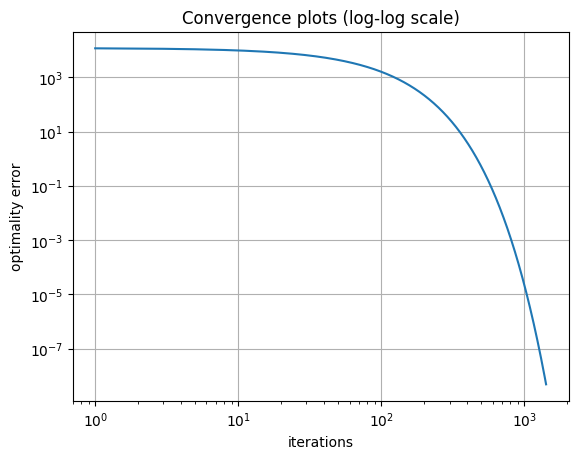

In [ ]:
x0 = np.array([10, 2])
x_star, fx_star = compute_optimal(Z, Y)
x_gd, f_values, runtime = gradient_descent(
    f=objective,
    gradient=gradient,
    alpha=0.01,
    x_start=x0,
    max_iter=10000,
    tol=1e-4
)

# Compute optimality errors
optimality_errors = [f - fx_star for f in f_values]

# Print results
print("Final optimality error:", optimality_errors[-1])
print("GD runtime:",runtime, "seconds")

# Plot in log-log scale
plt.loglog(range(1, len(optimality_errors)+1), optimality_errors)
plt.xlabel("iterations")
plt.ylabel("optimality error")
plt.title("Convergence plots (log-log scale)")
plt.grid()
plt.show()


#### 12.

In [70]:
def stochastic_gradient_descent(f,Y, Z, x_start, alpha=1.0, m=1, max_iter=10000, tol=1e-4):
    x = x_start.copy()
    N = len(Y)
    f_values = []
    start_time = time.time()

    for _ in range(max_iter):
        g = stochastic_gradient(Y, Z, x, m)
        x = x - alpha * g
        f_val = f(Y, Z, x)
        f_values.append(f_val)

        if np.linalg.norm(g) < tol:
            break

    runtime = time.time() - start_time
    return x, f_values, runtime

#### 13.

In [94]:
x_star, sdg_optimal = compute_optimal(Z, Y)
x0 = np.array([10, 2])

sdg_x, sdg_values, sdg_runtime = stochastic_gradient_descent(
    f=objective,
    Y=Y,
    Z=Z,
    x_start=x0,
    alpha=0.01,
    m=1,
    max_iter=10000,
    tol=1e-4
)

final_error = sdg_values[-1] - sdg_optimal

print("Final optimality error:", final_error)


Final optimality error: 0.01219200312775115


#### 14.

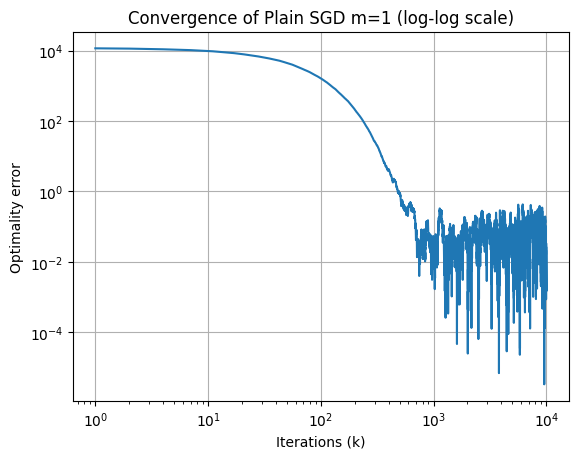

In [86]:
# Compute optimality errors over all iterations
sdg_errors = [f - sdg_optimal for f in sdg_values]

# Plot log-log
plt.loglog(range(1, len(sdg_errors)+1), sdg_errors)
plt.xlabel("Iterations (k)")
plt.ylabel("Optimality error")
plt.title("Convergence of Plain SGD m=1 (log-log scale)")
plt.grid()
plt.show()


#### 15.

In [89]:
x_star_10, sdg_optimal_10 = compute_optimal(Z, Y)
x0 = np.array([10, 2])

sdg_x_10, sdg_values_10, sdg_runtime_10 = stochastic_gradient_descent(
    f=objective,
    Y=Y,
    Z=Z,
    x_start=x0,
    alpha=0.01,
    m=10,
    max_iter=10000,
    tol=1e-4
)

final_error_10 = sdg_values_10[-1] - sdg_optimal_10

print("Final optimality error:", final_error_10)


Final optimality error: 0.12011538920963005


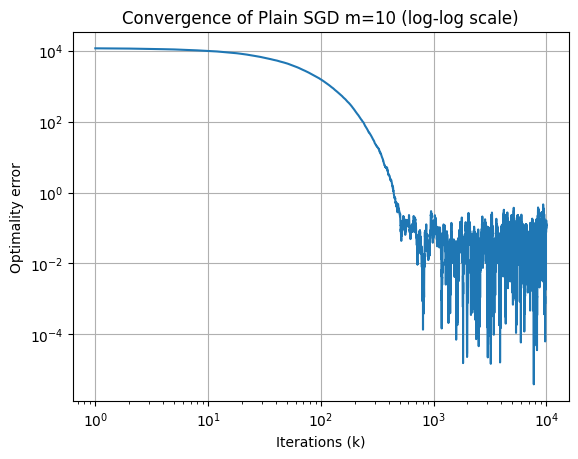

In [90]:
# Compute optimality errors over all iterations
sdg_errors_10 = [f - sdg_optimal_10 for f in sdg_values_10]

# Plot log-log
plt.loglog(range(1, len(sdg_errors_10)+1), sdg_errors_10)
plt.xlabel("Iterations (k)")
plt.ylabel("Optimality error")
plt.title("Convergence of Plain SGD m=10 (log-log scale)")
plt.grid()
plt.show()


The two graphs (the one with $m=1$ and the one with $m=10$) are very similar. In details, we have the same decreasing curve in the first half of the plot (before $k=10^{2.5}) with some small differences around iteration $k=10^3$ where the SDG with $m=10$ decreases a little bit more than SDG with $m=1$.  
After this, we can notice that also if the two plot are very similar in the oscillations after $k=10^3$, SDG with $k=10$ is a little bit less "noisy" (i.e. the maximum and minimum are less distant between each others).

#### 16.

In [97]:
def better_stochastic_gradient_descent(f, Y, Z, x_start, m=1, max_iter=10000, tol=1e-4):
    x = x_start.copy()
    N = len(Y)
    f_values = []
    start_time = time.time()

    for k in range(max_iter):
        g = stochastic_gradient(Y, Z, x, m)
        alpha_k = 1 / (k + 1)
        x = x - alpha_k * g

        f_val = f(Y, Z, x)
        f_values.append(f_val)

        if np.linalg.norm(g) < tol:
            break

    runtime = time.time() - start_time
    return x, f_values, runtime

#### 17.

In [101]:
x0 = np.array([10, 2])

x_star, optimal = compute_optimal(Z, Y)

x_bsgd, f_bsgd_vals, t_bsgd = better_stochastic_gradient_descent(
    f=objective,
    Y=Y,
    Z=Z,
    x_start=x0,
    m=10, # is not specified in the assignment, so I have chosen to use m=10 as in problem 15.
    max_iter=10000,
    tol=1e-4
)

err_bsgd = [f_k - optimal for f_k in f_bsgd_vals]
final_err_bsgd = err_bsgd[-1]

print("Final optimality error BSGD:", final_err_bsgd)
print("Runtime BSGD:", t_bsgd, "seconds")

Final optimality error BSGD: 0.0006063634245236926
Runtime BSGD: 5.404635190963745 seconds


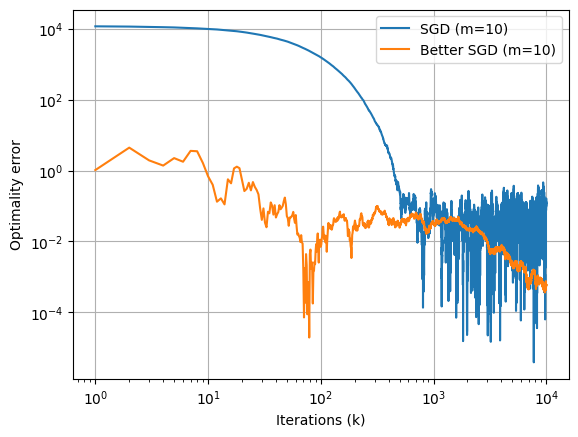

In [109]:
plt.loglog(range(1, len(sdg_errors_10)+1), sdg_errors_10, label="SGD (m=10)")
plt.loglog(range(1, len(err_bsgd)+1), err_bsgd, label="Better SGD (m=10)")
plt.xlabel("Iterations (k)")
plt.ylabel("Optimality error")
plt.grid()
plt.legend()
plt.show()

The plot shows that the _Better SDG_ has a slower descend compared to the _SDG_, but it also starts with a smaller optimality error, and is much more regular than the _SDG_ since the oscillation is very small.

_Better SDG_ decreases slower at the beginning because of the step size that is computed as $\alpha^{(k)} = \frac{1}{k+1}$. This means that at the beginning the step size will be quite big (around 1 with $k=0$), and then become smaller producing a more precise convergence. 

This makes the _Better SDG_ slower but much more precise.

#### 18.

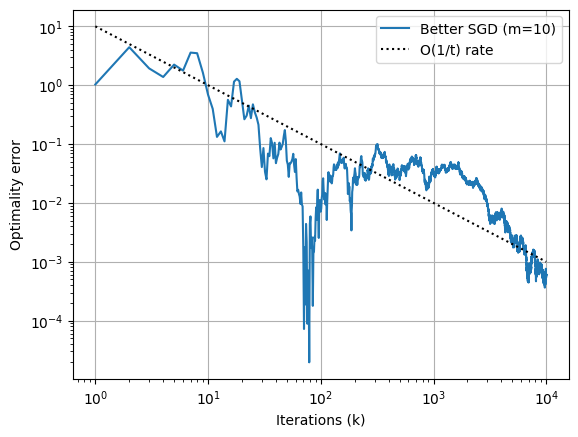

In [117]:
K = len(f_bsgd_vals)
k_vals = np.arange(1, K + 1)

theoretical_rate = 10 / k_vals

plt.loglog(k_vals, err_bsgd, label="Better SGD (m=10)")
plt.loglog(k_vals, theoretical_rate, 'k:', label="O(1/t) rate")

plt.xlabel("Iterations (k)")
plt.ylabel("Optimality error")
plt.grid()
plt.legend()
plt.show()
